# `analyze_optogenetics_constant_red.ipynb`

Plots results from R19G10>CsChrimson optogenetics experiment, in which flies experienced constant dark or constant red light for 15 minutes at a time. Creates Figure 2K and 2-S2 G.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import array
import os
import pandas as pd

def set_font_sizes(SMALL_SIZE=14, MEDIUM_SIZE=16, LARGE_SIZE=20):
    '''
    Sets font size for matplotlib
    From: https://stackoverflow.com/a/39566040
    '''
    font = {'family':'sans-serif',
            'sans-serif':['Arial'],
            'size': SMALL_SIZE}
    plt.rc('font', **font)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title
    
set_font_sizes()

def read_margo_binary_file(bin_file, MAX_N_FRAMES=int(1e9)):
    try:
        my_array = array.array("f")
        my_array.fromfile(open(bin_file, mode='rb'), MAX_N_FRAMES)
        # this is a trick! Let n be large, like the max number of frames. Then,
        # array.fromfile will read in up to n items. if n exceeds the number
        # of items in the actual file, a warning gets raised, but it'll still
        # load in the real number of items... so to suppress the warning, I
        # put this in a try: except and just return the object loaded with
        # however true items there are inside.
    except EOFError:
        my_array = np.array(my_array)
        
    return my_array 

### read in data

In [2]:
margo_bin_dir = '../../Data/Data by figure/Fig 2 + Supp/CsChrimson/05-24-2022-12-08-17__Basic_Tracking_R19G10orTM3SbUASCsChr_Mix_ATR_1-48_Day1/raw_data/'
margo_bin_files = [os.path.join(margo_bin_dir, x) for x in os.listdir(margo_bin_dir)]

t_file = [x for x in margo_bin_files if '__time' in x][0]
centroid_file = [x for x in margo_bin_files if '__centroid' in x][0]
speed_file = [x for x in margo_bin_files if '__speed' in x][0]

time_diff_array_sec = read_margo_binary_file(t_file)
raw_centroid_array_px = read_margo_binary_file(centroid_file)
raw_speed_array_px = read_margo_binary_file(speed_file)

In [3]:
time_array_sec = np.cumsum(time_diff_array_sec)
time_array_min = time_array_sec / 60

nT = len(time_diff_array_sec)
nROI = len(raw_centroid_array_px) / 2 / nT
nROI = int(nROI)

### tracking frame rate through the experiment

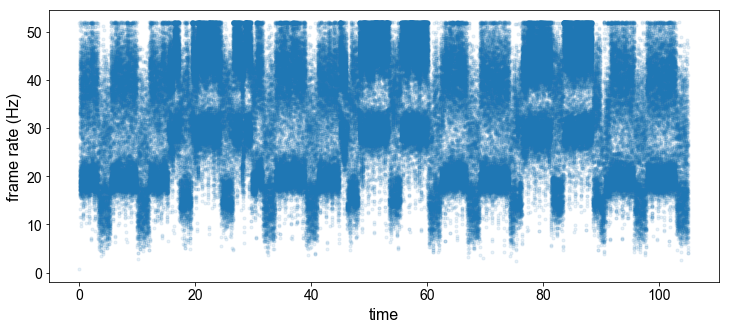

In [4]:
plt.figure(figsize=(12,5))
plt.scatter(np.cumsum(time_diff_array_sec)/60, 1/time_diff_array_sec, marker='.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('frame rate (Hz)')
plt.show()

plt.figure()
plt.hist(1/time_diff_array_sec, bins=50)
plt.xlabel('frame rate (Hz)')
plt.ylabel('# of frames')
plt.show()

### set mm per px

In [5]:
centroid_array_px = raw_centroid_array_px.reshape((nT,2,nROI))
speed_array_px = raw_speed_array_px.reshape((nT, nROI))

In [6]:
df_centroids = []
for i in range(nROI):
    minx = np.nanmin(centroid_array_px[:, 0, i])
    maxx = np.nanmax(centroid_array_px[:, 0, i])
    miny = np.nanmin(centroid_array_px[:, 1, i])
    maxy = np.nanmax(centroid_array_px[:, 1, i])
    df_centroids.append([i, minx, maxx, miny, maxy])
df_centroids = pd.DataFrame(df_centroids)
df_centroids.columns = ['roi', 'minx', 'maxx', 'miny', 'maxy']
df_centroids['xrange'] = df_centroids['maxx'] - df_centroids['minx']
df_centroids['yrange'] = df_centroids['maxy'] - df_centroids['miny']

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: All-NaN slice encountered
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: All-NaN slice encountered
  after removing the cwd from sys.path.
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: All-NaN slice encountered
  """
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: All-NaN slice encountered
  


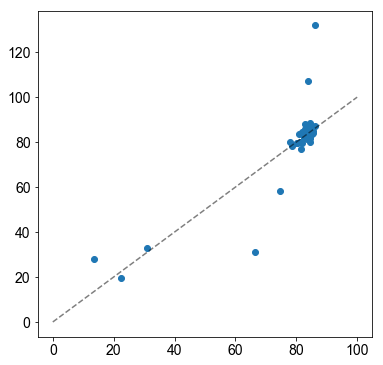

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(df_centroids['xrange'], df_centroids['yrange'])
plt.plot([0, 100], [0, 100], ls='--', alpha=0.5, c='k')
plt.show()

In [8]:
plt.figure()
plt.scatter(df_centroids['roi']+1, df_centroids['xrange'])
plt.xlabel('ROI')
plt.ylabel('x range (px)')
plt.show()

In [9]:
arena_diam_in_mm = 28
median_margo_xrange = np.nanmedian(df_centroids['xrange'])
mm_per_pix = arena_diam_in_mm / median_margo_xrange
#mm_per_pix = 0.295

In [10]:
plt.figure()
plt.axhline(arena_diam_in_mm, c='k', ls='--')
plt.scatter(df_centroids['roi']+1, df_centroids['xrange']*mm_per_pix)
plt.xlabel('ROI')
plt.ylabel('x range (mm)')
plt.show()

In [11]:
plt.figure(figsize=(7,6))
for i in range(nROI):
    roi_x = np.nanmean(centroid_array_px[:, 0, i] * mm_per_pix)
    roi_y = np.nanmean(centroid_array_px[:, 1, i] * mm_per_pix)
    if not np.isnan(roi_x):
        plt.text(roi_x, roi_y, f'{i+1}', color='k', ha='center', va='center')
    plt.plot(centroid_array_px[:, 0, i] * mm_per_pix, 
             centroid_array_px[:, 1, i] * mm_per_pix,
             alpha=0.7)
plt.axis('equal')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.gca().invert_yaxis()
#plt.savefig(os.path.join(plot_dir, 'raw_traces.png'), bbox_inches='tight', facecolor='white')
#plt.xlim(25,75)
#plt.ylim(10,50)
plt.show()

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [12]:
def get_spd_from_centroids_bin(centroids, time_diffs):
    '''
    Given centroids data (n_frames * 2 * nROI),
    returns speed (n_frames * nROI) by computing 
    COM distance between two consecutive frames.
    '''
    # initialize with zeros
    spds = np.zeros(shape=(centroids.shape[0], centroids.shape[2]))
    # spd(i) = sqrt( [ (x(i) -x(i-1) ]^2 + [ (y(i) -y(i-1) ]^2 )
    px_diffs = np.sum(np.diff(centroids, axis=0)**2, axis=1)**(1/2)
    spds[1:, :] = (px_diffs.T / time_diffs[1:]).T
    # finally, fill NaN's with 0
    return np.nan_to_num(spds)

In [13]:
speeds_mm_s = get_spd_from_centroids_bin(centroid_array_px*mm_per_pix, time_diff_array_sec)

## set speed maximum to remove tracking artifacts

In [14]:
vv = speeds_mm_s.flatten()
plt.figure(figsize=(12,5))
plt.hist(vv[~np.isnan(vv)], bins=100)
plt.semilogy()
plt.xlabel('speed (mm/s)')
plt.ylabel('fly-frames')
plt.show()

speed_cutoff = 60
where_too_fast = np.where(speeds_mm_s > speed_cutoff)
speeds_mm_s[where_too_fast[0], where_too_fast[1]] = np.nan

vv = speeds_mm_s.flatten()
plt.figure(figsize=(12,5))
plt.hist(vv[~np.isnan(vv)], bins=100)
plt.semilogy()
plt.xlabel('speed (mm/s)')
plt.ylabel('fly-frames')
plt.show()

### label fly conditions

In [15]:
TM3_minus_is = 1 + np.arange(0, 48, 4) - 1
TM3_plus_is = 2 + np.arange(0, 48, 4) - 1
R19_minus_is = 3 + np.arange(0, 48, 4) - 1
R19_plus_is = 4 + np.arange(0, 48, 4) - 1
TM3_minus_is, TM3_plus_is, R19_minus_is, R19_plus_is

cond_is = [R19_plus_is, R19_minus_is, TM3_plus_is, TM3_minus_is]

cond_names = ['R19G10 > CsChr (ATR +)', 
              'R19G10 > CsChr (ATR -)', 
              'TM3, Sb; UAS-CsChr (ATR +)',
              'TM3, Sb; UAS-CsChr (ATR -)']

In [16]:
len(np.concatenate((TM3_minus_is, TM3_plus_is, R19_minus_is, R19_plus_is)))

48

In [17]:
def i_to_cond(i):
    if i in R19_plus_is:
        return 0
    elif i in R19_minus_is:
        return 1
    elif i in TM3_plus_is:
        return 2
    elif i in TM3_minus_is:
        return 3
    return 100

### set red light timings

In [18]:
transition_times = 60 + 45 - np.array([60 + 45, # start
                                       60+30, # off to red
                                       60+15+22/60, # red to off
                                       60, # off to red
                                       44+45/60, # red to off
                                       30, # off to red
                                       15+10/60, # red to off
                                       0 # end
                                      ])

In [19]:
n_conds = len(transition_times) -1
start_cond = 'off'
df_conds = []
for i in range(n_conds):
    cond = 'off' if i % 2 == 0 else 'red'
    df_conds.append([cond, transition_times[i], transition_times[i+1]])
df_conds = pd.DataFrame(df_conds)
df_conds.columns = ['condition', 'start', 'end']
df_conds

condition      start         end
0       off   0.000000   15.000000
1       red  15.000000   29.633333
2       off  29.633333   45.000000
3       red  45.000000   60.250000
4       off  60.250000   75.000000
5       red  75.000000   89.833333
6       off  89.833333  105.000000

### speeds through time under red/dark conditions

In [20]:
plot_dir = 'optogenetics_constant_red'
   
SAVE_PLOTS = False

if SAVE_PLOTS:
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

In [21]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

w = 1000
show_smooth = 0
fig, axs = plt.subplots(4, 1, figsize=(10,9), sharex=True, sharey=True)
for i in range(nROI):
    ax = axs[i_to_cond(i)]
    
    if show_smooth:
        ax.plot(time_array_min[:-w+1], moving_average(speeds_mm_s[:, i], w), alpha=1)
    else:
        ax.plot(time_array_min, speeds_mm_s[:, i], alpha=0.25, c='k')

red_df = df_conds[df_conds.condition == 'red']
for i in range(4):
    axs[i].set_title(cond_names[i])
    
    for j in range(len(red_df)):
        strt, stp = red_df.iloc[j][['start', 'end']]
        axs[i].axvspan(strt,stp, alpha=0.1, color='red')

plt.xlabel('time (min)')
plt.ylabel('speed (mm/s)')

#plt.xlim(10, 20)
#plt.ylim(0, 6)
plt.xticks(np.arange(min(time_array_min), max(time_array_min)+1, 15))
#plt.savefig(os.path.join(plot_dir, 'speeds_through_time.png'), bbox_inches='tight', facecolor='white')

plt.show()

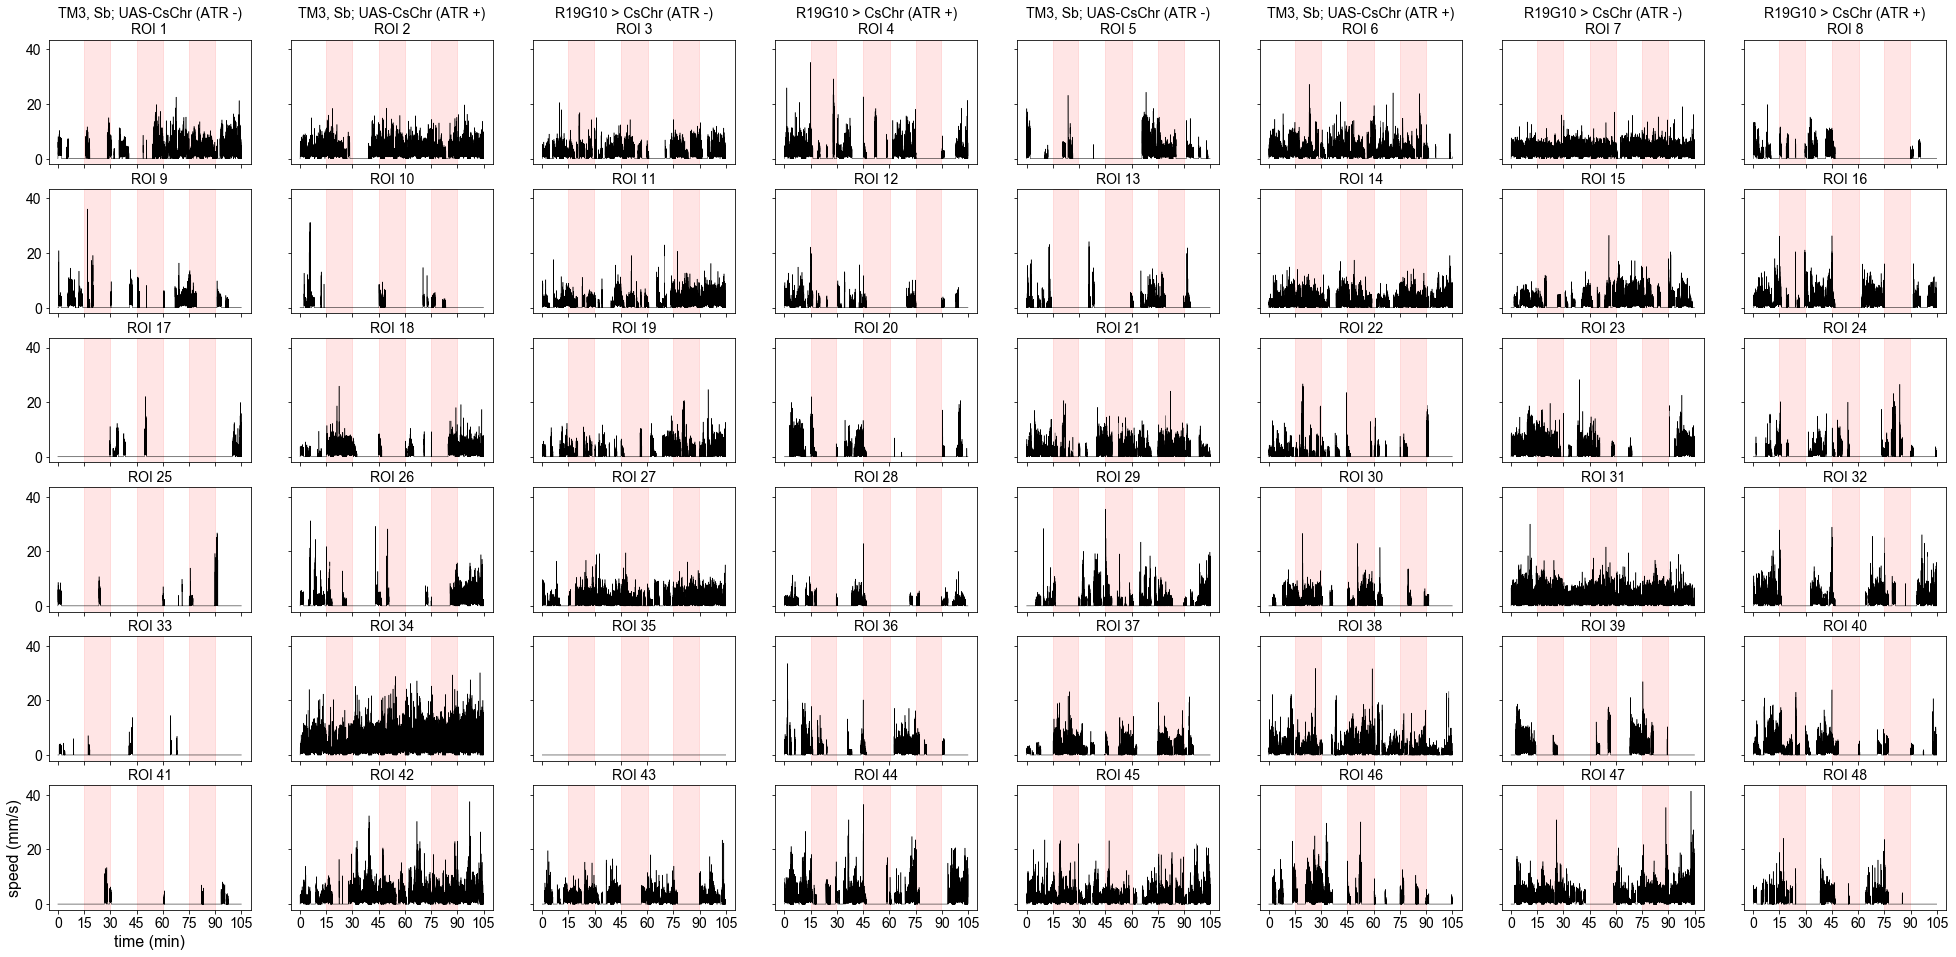

In [22]:
w = 5
show_smooth = 1
smooth_lw = 0.5
alph = 1

fig, axs = plt.subplots(6, 8, figsize=(34, 16), sharex=True, sharey=True)
for i in range(48):
    row_i = i // 8
    col_i = i % 8
    ax = axs[row_i, col_i]
    ax.set_title('ROI {}'.format(i + 1))
    
    
    if show_smooth:
        ax.plot(time_array_min[:-w+1], moving_average(speeds_mm_s[:, i], w), alpha=alph, lw=smooth_lw, c='k')
    else:
        ax.plot(time_array_min, speeds_mm_s[:, i], alpha=alph, c='k')

    for j in range(len(red_df)):
        strt, stp = red_df.iloc[j][['start', 'end']]
        ax.axvspan(strt,stp, alpha=0.1, color='red')
    ax.set_xticks(np.arange(min(time_array_min), max(time_array_min)+1, 15))
    #ax.set_ylim(0,6)
    
axs[-1, 0].set_xlabel('time (min)')
axs[-1, 0].set_ylabel('speed (mm/s)')

for i in range(8):
    axs[0, i].set_title(cond_names[i_to_cond(i)]+f'\nROI {i+1}')
#plt.savefig('full_ROI_tracking.png', facecolor='white', bbox_inches='tight', dpi=400)
plt.show()

What fraction of flies are immobile through time?

C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


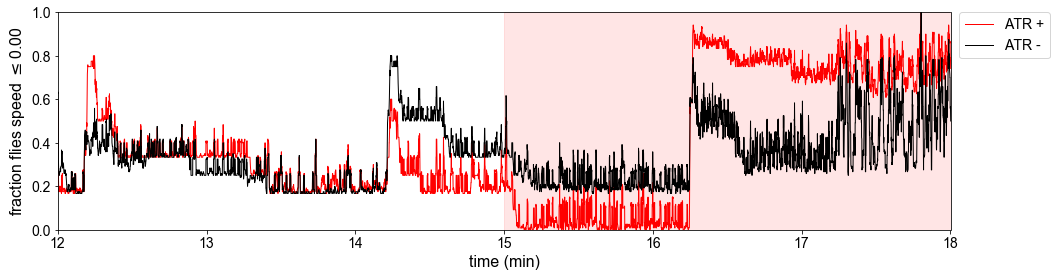

In [23]:
w = 10
slow_speed_thresh = 0.0
frac_slow_R19_plus = np.sum(speeds_mm_s[:, R19_plus_is] <= slow_speed_thresh, 1)/12
frac_slow_R19_minus = np.sum(speeds_mm_s[:, R19_minus_is] <= slow_speed_thresh, 1)/12

fig, ax = plt.subplots(1,1,figsize=(16,4))
plt.plot(time_array_min[:-w+1], moving_average(frac_slow_R19_plus, w), c='r', lw=1, label='ATR +')
plt.plot(time_array_min[:-w+1], moving_average(frac_slow_R19_minus, w), c='k', lw=1, label='ATR -')

for j in range(len(red_df)):
    strt, stp = red_df.iloc[j][['start', 'end']]
    ax.axvspan(strt,stp, alpha=0.1, color='red')
    
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
plt.xlabel('time (min)')
plt.ylabel(r'fraction flies speed $\leq$' + '{:.2f}'.format(slow_speed_thresh))
plt.ylim(0, 1)
plt.xlim(12,18)
plt.show()

### ATR + / ATR - group analysis

In [24]:
cond_is = [R19_plus_is, R19_minus_is, TM3_plus_is, TM3_minus_is]

In [25]:
dark1_indices = np.where((time_array_min >= transition_times[0]) & (time_array_min < transition_times[1]))[0]
red1_indices = np.where((time_array_min >= transition_times[1]) & (time_array_min < transition_times[2]))[0]

dark1_times = time_array_min[dark1_indices]
red1_times = time_array_min[red1_indices]


ATR_dark1_speeds = speeds_mm_s[dark1_indices, :][:, R19_plus_is]
no_ATR_dark1_speeds = speeds_mm_s[dark1_indices, :][:, R19_minus_is]

ATR_red1_speeds = speeds_mm_s[red1_indices, :][:, R19_plus_is]
no_ATR_red1_speeds = speeds_mm_s[red1_indices, :][:, R19_minus_is]

In [26]:
wl = 5/60
time_bins = np.arange(0, 15, wl)
n_time_bins = len(time_bins)


dark1_times_centered = dark1_times - dark1_times[0]
bin_time_indices = np.array([np.where(t >= time_bins)[0][-1] for t in dark1_times_centered])

ATR_dark_binned_mean_speeds = []
ATR_dark_binned_se_speeds = []
no_ATR_dark_binned_mean_speeds = []
no_ATR_dark_binned_se_speeds = []

for i in range(n_time_bins-1):
    cur_time_indices = np.where(bin_time_indices == i)[0]
    
    bin_ATR_speeds = ATR_dark1_speeds[cur_time_indices]
    bin_no_ATR_speeds = no_ATR_dark1_speeds[cur_time_indices]
    
    ATR_dark_binned_mean_speeds.append(np.nanmean(bin_ATR_speeds))
    ATR_dark_binned_se_speeds.append(np.nanstd(bin_ATR_speeds) / np.sqrt(12))#/ np.prod(np.shape(bin_ATR_speeds)))
    
    no_ATR_dark_binned_mean_speeds.append(np.nanmean(bin_no_ATR_speeds))
    no_ATR_dark_binned_se_speeds.append(np.nanstd(bin_no_ATR_speeds) / np.sqrt(12))#/ np.sqrt(np.prod(np.shape(bin_no_ATR_speeds))))
    
ATR_dark_binned_mean_speeds = np.array(ATR_dark_binned_mean_speeds)
ATR_dark_binned_se_speeds = np.array(ATR_dark_binned_se_speeds)
no_ATR_dark_binned_mean_speeds = np.array(no_ATR_dark_binned_mean_speeds)
no_ATR_dark_binned_se_speeds = np.array(no_ATR_dark_binned_se_speeds)

red1_times_centered = red1_times - red1_times[0]
bin_time_indices = np.array([np.where(t >= time_bins)[0][-1] for t in red1_times_centered])

ATR_red_binned_mean_speeds = []
ATR_red_binned_se_speeds = []
no_ATR_red_binned_mean_speeds = []
no_ATR_red_binned_se_speeds = []

for i in range(n_time_bins-1):
    cur_time_indices = np.where(bin_time_indices == i)[0]
    
    bin_ATR_speeds = ATR_red1_speeds[cur_time_indices]
    bin_no_ATR_speeds = no_ATR_red1_speeds[cur_time_indices]
    
    ATR_red_binned_mean_speeds.append(np.nanmean(bin_ATR_speeds))
    ATR_red_binned_se_speeds.append(np.nanstd(bin_ATR_speeds) / np.sqrt(12))#/ np.prod(np.shape(bin_ATR_speeds)))
    
    no_ATR_red_binned_mean_speeds.append(np.nanmean(bin_no_ATR_speeds))
    no_ATR_red_binned_se_speeds.append(np.nanstd(bin_no_ATR_speeds) / np.sqrt(12))#np.sqrt(np.prod(np.shape(bin_no_ATR_speeds))))
    
ATR_red_binned_mean_speeds = np.array(ATR_red_binned_mean_speeds)
ATR_red_binned_se_speeds = np.array(ATR_red_binned_se_speeds)
no_ATR_red_binned_mean_speeds = np.array(no_ATR_red_binned_mean_speeds)
no_ATR_red_binned_se_speeds = np.array(no_ATR_red_binned_se_speeds)


fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)
alph = 0.25

# ATR -, dark
axs[0].plot(time_bins[:-1], no_ATR_dark_binned_mean_speeds, c='k')
axs[0].fill_between(time_bins[:-1], 
                 no_ATR_dark_binned_mean_speeds-no_ATR_dark_binned_se_speeds,
                 no_ATR_dark_binned_mean_speeds+no_ATR_dark_binned_se_speeds, 
                 color='k', alpha=alph)

# ATR -, red
axs[0].plot(time_bins[:-1], no_ATR_red_binned_mean_speeds, c='r')
axs[0].fill_between(time_bins[:-1], 
                 no_ATR_red_binned_mean_speeds-no_ATR_red_binned_se_speeds,
                 no_ATR_red_binned_mean_speeds+no_ATR_red_binned_se_speeds, 
                 color='r', alpha=alph)

# ATR +, dark
axs[1].plot(time_bins[:-1], ATR_dark_binned_mean_speeds, c='k', label='dark')
axs[1].fill_between(time_bins[:-1], 
                 ATR_dark_binned_mean_speeds-ATR_dark_binned_se_speeds,
                 ATR_dark_binned_mean_speeds+ATR_dark_binned_se_speeds, 
                 color='k', alpha=alph)

# ATR +, red
axs[1].plot(time_bins[:-1], ATR_red_binned_mean_speeds, c='r', label='red light')
axs[1].fill_between(time_bins[:-1], 
                 ATR_red_binned_mean_speeds-ATR_red_binned_se_speeds,
                 ATR_red_binned_mean_speeds+ATR_red_binned_se_speeds, 
                 color='r', alpha=alph)

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)
axs[0].set_xticks(np.arange(0, 15.1, 3))
axs[0].set_title('ATR -')
axs[1].set_title('ATR +')
axs[0].set_xlim(0, 15)
axs[0].set_xlabel('time spent in condition (min)')
axs[0].set_ylabel('speed (mm/s)')

plt.subplots_adjust(wspace=0.1)
plt.show()


C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\dB\Anaconda3\envs\classifier\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


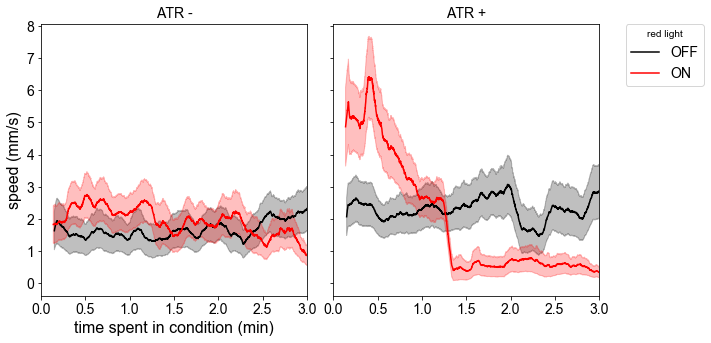

In [27]:
wl = 200
alph = 0.25
xmax = 3
xtick_width = 0.5

ATR_red1_mean = pd.Series(np.nanmean(ATR_red1_speeds, 1)).rolling(wl, axis=0).mean()
no_ATR_red1_mean = pd.Series(np.nanmean(no_ATR_red1_speeds, 1)).rolling(wl, axis=0).mean()
ATR_dark1_mean = pd.Series(np.nanmean(ATR_dark1_speeds, 1)).rolling(wl, axis=0).mean()
no_ATR_dark1_mean = pd.Series(np.nanmean(no_ATR_dark1_speeds, 1)).rolling(wl, axis=0).mean()

ATR_red1_se = pd.Series(np.nanstd(ATR_red1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()
no_ATR_red1_se = pd.Series(np.nanstd(no_ATR_red1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()
ATR_dark1_se = pd.Series(np.nanstd(ATR_dark1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()
no_ATR_dark1_se = pd.Series(np.nanstd(no_ATR_dark1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True, facecolor='white')

# ATR -, dark
axs[0].plot(dark1_times_centered, no_ATR_dark1_mean, c='k')
axs[0].fill_between(dark1_times_centered, 
                 no_ATR_dark1_mean-no_ATR_dark1_se,
                 no_ATR_dark1_mean+no_ATR_dark1_se, 
                 color='k', alpha=alph)

# ATR -, red
axs[0].plot(red1_times_centered, no_ATR_red1_mean, c='r')
axs[0].fill_between(red1_times_centered, 
                 no_ATR_red1_mean-no_ATR_red1_se,
                 no_ATR_red1_mean+no_ATR_red1_se, 
                 color='r', alpha=alph)

# ATR +, dark
axs[1].plot(dark1_times_centered, ATR_dark1_mean, c='k', label='OFF')
axs[1].fill_between(dark1_times_centered, 
                 ATR_dark1_mean-ATR_dark1_se,
                 ATR_dark1_mean+ATR_dark1_se, 
                 color='k', alpha=alph)

# ATR +, red
axs[1].plot(red1_times_centered, ATR_red1_mean, c='r', label='ON')
axs[1].fill_between(red1_times_centered, 
                 ATR_red1_mean-ATR_red1_se,
                 ATR_red1_mean+ATR_red1_se, 
                 color='r', alpha=alph)

plt.legend(title='red light', loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0)
axs[0].set_title('ATR -')
axs[1].set_title('ATR +')
axs[0].set_xlim(0, xmax)
axs[0].set_xticks(np.arange(0, xmax+0.001, xtick_width))
axs[0].set_xlabel('time spent in condition (min)')
axs[0].set_ylabel('speed (mm/s)')

plt.subplots_adjust(wspace=0.1)
#plt.savefig(os.path.join(plot_dir, 'moving_average_time_in_cond_3_min.png'), 
#            bbox_inches='tight', facecolor='white')
plt.show()

## Figure 2K
Zoom in to transition from dark to red light, for both ATR- and ATR+ flies

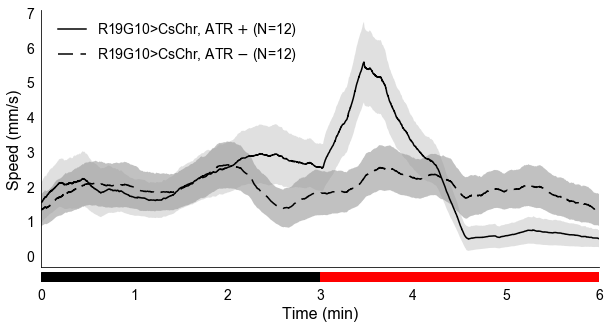

In [28]:
wl = 750
alph = 0.6
#xmax = 30
xtick_width = 1

trial1_indices = np.where(time_array_min <= transition_times[2])[0]
trial1_times_centered = time_array_min[trial1_indices] - transition_times[1] + 3
ATR_trial1_speeds = speeds_mm_s[trial1_indices, :][:, R19_plus_is]
no_ATR_trial1_speeds = speeds_mm_s[trial1_indices, :][:, R19_minus_is]

ATR_trial1_mean = pd.Series(np.nanmean(ATR_trial1_speeds, 1)).rolling(wl, axis=0).mean()
no_ATR_trial1_mean = pd.Series(np.nanmean(no_ATR_trial1_speeds, 1)).rolling(wl, axis=0).mean()

ATR_trial1_se = pd.Series(np.nanstd(ATR_trial1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()
no_ATR_trial1_se = pd.Series(np.nanstd(no_ATR_trial1_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()

fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=False, gridspec_kw={'height_ratios': [25, 1]}, facecolor='white')

ax = axs[0]

# ATR +
ax.plot(trial1_times_centered, ATR_trial1_mean, 
        c='k', label=r'R19G10>CsChr, ATR $+$ (N=12)')
ax.fill_between(trial1_times_centered, 
                 ATR_trial1_mean-ATR_trial1_se,
                 ATR_trial1_mean+ATR_trial1_se, 
                 color='0.8', alpha=alph, lw=0)

# ATR -
ax.plot(trial1_times_centered, no_ATR_trial1_mean, 
        c='k', ls='--', label=r'R19G10>CsChr, ATR $-$ (N=12)',
        dashes=[10,5])
ax.fill_between(trial1_times_centered, 
                 no_ATR_trial1_mean-no_ATR_trial1_se,
                 no_ATR_trial1_mean+no_ATR_trial1_se, 
                 color='0.6', alpha=alph, lw=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), borderaxespad=0, frameon=False)
ax.set_ylabel('Speed (mm/s)')
ax.set_xticks([])
ax.yaxis.set_ticks_position('none') 

ax = axs[1]
ax.axvspan(0, 3, alpha=1, color='k')
ax.axvspan(3, 6, alpha=1, color='r')


#ax.set_xticks(np.arange(0, xmax+0.001, xtick_width))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_yticks([])
ax.set_xlabel('Time (min)')

plt.subplots_adjust(hspace=0.03)

for ax in axs:
    ax.set_xlim(0, 6)

#plt.savefig(os.path.join(plot_dir, 'moving_average_one_panel_3_min.png'), bbox_inches='tight')
#plt.savefig(os.path.join(plot_dir, 'moving_average_one_panel_3_min.pdf'), bbox_inches='tight')
#plt.savefig(os.path.join(plot_dir, 'moving_average_one_panel_3_min.svg'), bbox_inches='tight')

plt.show()

## Figure 2-S2 G
Zoom in to transition from dark to red light for the second red light presentation, for both ATR- and ATR+ flies

In [ ]:
wl = 750
alph = 0.6
#xmax = 30
xtick_width = 1

t_time = transition_times[3]
trial2_indices = np.where((time_array_min >= t_time - 4) & (time_array_min <= t_time + 4))[0]
trial2_times_centered = time_array_min[trial2_indices] - t_time
ATR_trial2_speeds = speeds_mm_s[trial2_indices, :][:, R19_plus_is]
no_ATR_trial2_speeds = speeds_mm_s[trial2_indices, :][:, R19_minus_is]

ATR_trial2_mean = pd.Series(np.nanmean(ATR_trial2_speeds, 1)).rolling(wl, axis=0).mean()
no_ATR_trial2_mean = pd.Series(np.nanmean(no_ATR_trial2_speeds, 1)).rolling(wl, axis=0).mean()

ATR_trial2_se = pd.Series(np.nanstd(ATR_trial2_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()
no_ATR_trial2_se = pd.Series(np.nanstd(no_ATR_trial2_speeds, 1) / np.sqrt(12)).rolling(wl, axis=0).mean()

fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=False, gridspec_kw={'height_ratios': [25, 1]}, facecolor='white')

ax = axs[0]

# ATR +
ax.plot(trial2_times_centered, ATR_trial2_mean, 
        c='k', label=r'R19G10>CsChr, ATR $+$ (N=12)')
ax.fill_between(trial2_times_centered, 
                 ATR_trial2_mean-ATR_trial2_se,
                 ATR_trial2_mean+ATR_trial2_se, 
                 color='0.8', alpha=alph, lw=0)

# ATR -
ax.plot(trial2_times_centered, no_ATR_trial2_mean, 
        c='k', ls='--', label=r'R19G10>CsChr, ATR $-$ (N=12)',
        dashes=[10,5])
ax.fill_between(trial2_times_centered, 
                 no_ATR_trial2_mean-no_ATR_trial2_se,
                 no_ATR_trial2_mean+no_ATR_trial2_se, 
                 color='0.6', alpha=alph, lw=0)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), borderaxespad=0, frameon=False)
ax.set_ylabel('Speed (mm/s)')
ax.set_xticks([])
ax.yaxis.set_ticks_position('none') 

ax.set_ylim(*trial1_ylims)

ax = axs[1]
ax.axvspan(-3, 0, alpha=1, color='k')
ax.axvspan(0, 3, alpha=1, color='r')

#ax.set_xticks(np.arange(0, xmax+0.001, xtick_width))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax.set_yticks([])
ax.set_xlabel('Time since constant red light (min)')

plt.subplots_adjust(hspace=0.01)

for ax in axs:
    ax.set_xlim(-3, 3)

plt.suptitle('Trial 2')


#plt.savefig(os.path.join(plot_dir, 'moving_average_constant_red_trial_trial2_crop.png'), bbox_inches='tight')
#plt.savefig(os.path.join(plot_dir, 'moving_average_constant_red_trial_trial2_crop.pdf'), bbox_inches='tight')
#plt.savefig(os.path.join(plot_dir, 'moving_average_constant_red_trial_trial2_crop.svg'), bbox_inches='tight')


plt.show()